In [17]:
!pip install meteostat

#1 Load Libraries

In [18]:
from meteostat import Point, Daily
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Cài đặt hiển thị rộng hơn cho DataFrame
pd.set_option('display.width', 1000)  # Độ rộng tối đa
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng
pd.options.display.float_format = '{:,.0f}'.format

#2 Load Data

In [19]:
# Tọa độ (lat, lon)
hcm = Point(10.82302, 106.62965) # check ở đây https://www.geonames.org/search.html?q=&country=VN

# Ngày cần lấy dữ liệu
start = datetime(1990, 1, 1)
end = datetime.today() - timedelta(days=1)  #  ngày hôm qua

# Lấy dữ liệu
df = Daily(hcm, start, end)
df = df.fetch()

# In nhiệt độ trung bình
print(df.head(20))

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun
time                                                                  
1990-01-01    27   NaN   NaN     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-02    27    22    33     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-03    27    21    33     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-04    27   NaN    32     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-05    27    22   NaN     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-06    26    19    32     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-07    27    19   NaN     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-08    28    22    32     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-09    28   NaN    33     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-10    27   NaN    34     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-11    28    23    34     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-01-12    27    23    35     0   NaN   NaN   NaN   NaN   NaN   NaN
1990-0

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12868 entries, 1990-01-01 to 2025-03-25
Freq: D
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    12860 non-null  float64
 1   tmin    10446 non-null  float64
 2   tmax    11759 non-null  float64
 3   prcp    4780 non-null   float64
 4   snow    0 non-null      float64
 5   wdir    4781 non-null   float64
 6   wspd    8105 non-null   float64
 7   wpgt    0 non-null      float64
 8   pres    3956 non-null   float64
 9   tsun    0 non-null      float64
dtypes: float64(10)
memory usage: 1.1 MB


In [21]:
print(df.isnull().sum())  # Kiểm tra giá trị thiếu

tavg        8
tmin     2422
tmax     1109
prcp     8088
snow    12868
wdir     8087
wspd     4763
wpgt    12868
pres     8912
tsun    12868
dtype: int64


#3 Data Wrangling

In [22]:
# Điền giá trị bị thiếu bằng nội suy tuyến tính
df.interpolate(method='linear', inplace=True)

In [23]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['tavg'].values.reshape(-1, 1))

#4 Create Sequences for LSTM Model
Tạo tập dữ liệu chuỗi thời gian

In [24]:
def create_sequences(df, time_steps):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df[i:i + time_steps])  # Chuỗi 356 ngày trước
        y.append(df[i + time_steps])    # Giá trị ngày tiếp theo
    return np.array(X), np.array(y)

time_steps = 365
X, y = create_sequences(scaled_data, time_steps)

print(f"Kích thước X: {X.shape}, Kích thước y: {y.shape}")

Kích thước X: (12503, 365, 1), Kích thước y: (12503, 1)


#5 Split Data into Train, Validation, and Test Sets

In [25]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Kích thước tập huấn luyện: {X_train.shape}, Kích thước tập kiểm tra: {X_test.shape}")

Kích thước tập huấn luyện: (10002, 365, 1), Kích thước tập kiểm tra: (2501, 365, 1)


#6 Build and Train LSTM Model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 48s 162ms/step - loss: 0.0464 - val_loss: 0.0067
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 47s 167ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 164ms/step - loss: 0.0083 - val_loss: 0.0055
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 169ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 165ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 168ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 47s 167ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 166ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 12/50
282/282

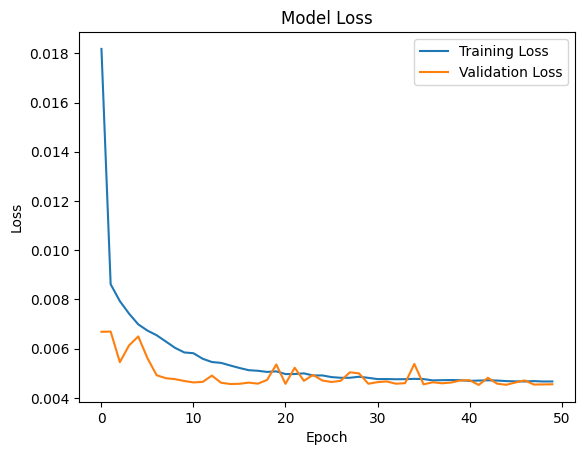

In [26]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, 1)))  # Lớp LSTM với 50 units
model.add(Dropout(0.2))  # Thêm Dropout để tránh overfitting
model.add(Dense(units=1))  # Lớp đầu ra dự báo 1 giá trị

model.compile(optimizer='adam', loss='mean_squared_error')  # Biên dịch mô hình với loss MSE
model.summary()  # Xem cấu trúc mô hình

# Train LSTM Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Vẽ biểu đồ loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#7 Prediction
Sử dụng mô hình đã huấn luyện để dự báo trên tập kiểm tra.

In [27]:
y_pred = model.predict(X_test)

# Đưa dữ liệu dự báo và thực tế về thang gốc
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

print("5 giá trị dự báo đầu tiên:", y_pred_inverse[:5].flatten())
print("5 giá trị thực tế đầu tiên:", y_test_inverse[:5].flatten())

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
5 giá trị dự báo đầu tiên: [28.017689 28.653719 27.866135 28.71199  27.884598]
5 giá trị thực tế đầu tiên: [28.6 27.1 28.9 27.3 30.1]


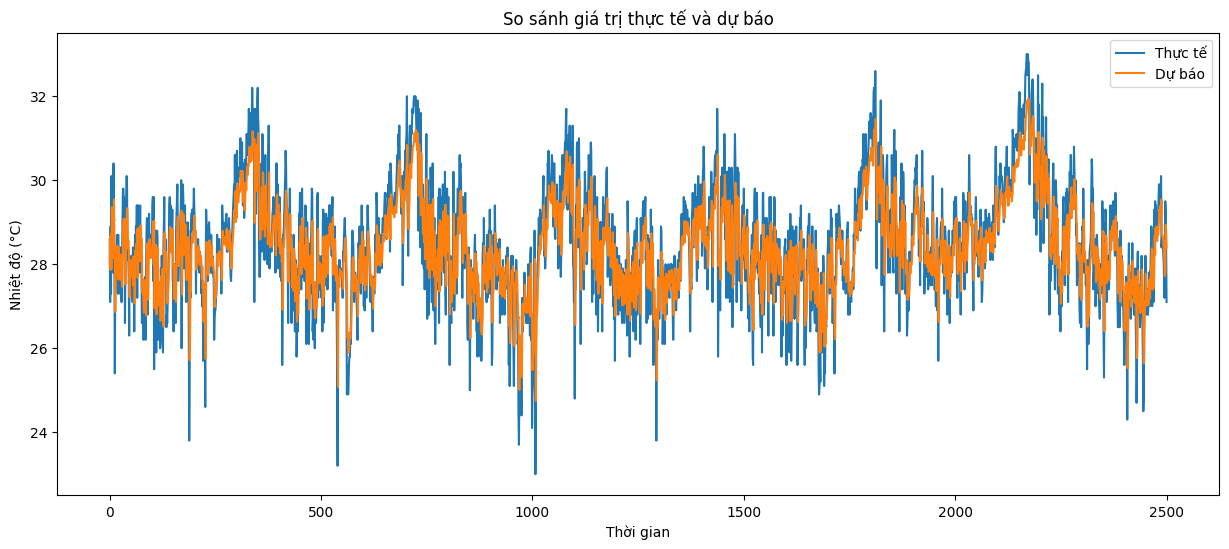

In [28]:
# Plot Actual vs Predicted Temperature
plt.figure(figsize=(15, 6))
plt.plot(y_test_inverse, label='Thực tế')
plt.plot(y_pred_inverse, label='Dự báo')
plt.title('So sánh giá trị thực tế và dự báo')
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ (°C)')
plt.legend()
plt.show()

#8 Evaluate Model Performance

In [29]:
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 0.90
MAE: 0.70
R²: 0.60


60-Day Temperature

In [30]:
# Lấy 365 ngày cuối cùng từ dữ liệu
last_sequence = scaled_data[-time_steps:]
last_sequence = last_sequence.reshape((1, time_steps, 1))

# Chuỗi dự báo
future_predictions = []
for _ in range(60):
    # Dự báo 1 ngày tiếp theo
    next_day_pred = model.predict(last_sequence)
    future_predictions.append(next_day_pred[0][0])

    # Cập nhật last_sequence với dự báo mới
    last_sequence = np.concatenate((last_sequence[:, 1:, :], next_day_pred.reshape(1, 1, 1)), axis=1)


future_pred_inverse = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Tạo mảng ngày cho dự báo
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=60)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

In [31]:
# Tạo DataFrame cho dự báo 60 ngày tới
future_data = {'Ngày': future_dates, 'Nhiệt độ (°C)': future_pred_inverse.flatten()}
future_df = pd.DataFrame(future_data)

# Đảm bảo cột 'Nhiệt độ (°C)' không bị làm tròn khi hiển thị
pd.set_option('display.float_format', '{:.2f}'.format)

# In bảng dữ liệu
future_df

,Ngày,Nhiệt độ (°C)
0,2025-03-26,27.67
1,2025-03-27,27.89
2,2025-03-28,27.99
3,2025-03-29,28.04
4,2025-03-30,28.05
5,2025-03-31,28.05
6,2025-04-01,28.05
7,2025-04-02,28.05
8,2025-04-03,28.04
9,2025-04-04,28.04


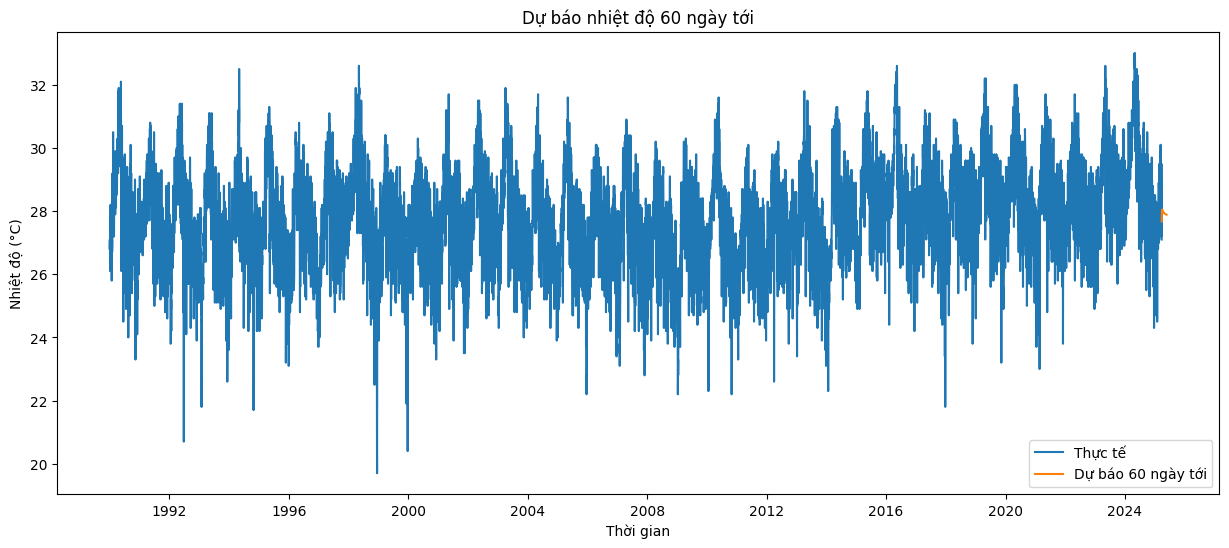

In [32]:
# Plot Actual vs Predicted Temperature
plt.figure(figsize=(15, 6))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Thực tế')
plt.plot(future_dates, future_pred_inverse, label='Dự báo 60 ngày tới')
plt.title('Dự báo nhiệt độ 60 ngày tới')
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ (°C)')
plt.legend()
plt.show()